In [142]:
!apt-get update # Update apt-get repository.
!apt-get install openjdk-8-jdk-headless -qq > /dev/null # Install Java.
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz # Download Apache Sparks.
!tar xf spark-3.1.1-bin-hadoop3.2.tgz # Unzip the tgz file.
!pip install -q findspark # Install findspark. Adds PySpark to the System path during runtime.

# Set environment variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

# Initialize findspark
import findspark
findspark.init()

# Create a PySpark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done


In [143]:
# Import CSV files into spark DataFrame.
spy_spark_df = spark.read.csv("SPY.csv")
vix_spark_df = spark.read.csv("VIX.csv")

# Convert to Pandas DataFrame for cleaning.
import pandas as pd
spy_df = spy_spark_df.toPandas()
vix_df = vix_spark_df.toPandas()

In [144]:
# Drop unnecessary columns.
vix_df = vix_df.drop(columns=['_c1', '_c2', '_c3', '_c5', '_c6'])

# Rename columns and drop index numbers.
spy_df = spy_df.rename(columns={"_c0": "Date", "_c1": "Open", "_c2": "High", "_c3": "Low", "_c4": "Close", "_c5": "Adj Close", "_c6": "Volume"})
spy_df = spy_df.drop([0])

vix_df = vix_df.rename(columns={"_c0": "Date", "_c4": "VIX"})
vix_df = vix_df.drop([0])

In [147]:
# Merge the SPY and VIX DataFrames.
combined_df = pd.merge(spy_df, vix_df, how='outer', on='Date')

# Set Date column as the dataframe index.
combined_df['Date'] = pd.to_datetime(combined_df['Date'])
combined_df.set_index('Date', inplace=True)

# Convert data in columns from objects to numeric.
for col in combined_df.columns:
    combined_df[col] = pd.to_numeric(combined_df[col], errors='ignore')

# Dropping last column because it contains a NA value.
combined_df = combined_df[:-1]

# Reducing the number size of the volume data to help the model run faster.
combined_df["Volume"] = combined_df["Volume"].div(1000000)
combined_df["Volume"] = combined_df["Volume"].round(1)

combined_df.head()

,Open,High,Low,Close,Adj Close,Volume,VIX
Date,,,,,,,
1993-01-25,43.96875,43.96875,43.75000,43.93750,24.840683,1.0,12.42
1993-02-01,43.96875,45.09375,43.96875,44.96875,25.423706,2.2,12.90
1993-02-08,44.96875,45.12500,44.53125,44.59375,25.211708,1.2,12.38
1993-02-15,44.46875,44.46875,42.81250,43.56250,24.628672,1.0,15.02
1993-02-22,43.68750,44.43750,43.46875,44.40625,25.105690,1.0,13.16


In [148]:
# Create "SPY Tomorrow" column and "Target" column.
combined_df["SPY Tomorrow"] = combined_df["Adj Close"].shift(-1)
combined_df["Target"] = (combined_df["SPY Tomorrow"] > combined_df["Adj Close"]).astype(int)

combined_df

,Open,High,Low,Close,Adj Close,Volume,VIX,SPY Tomorrow,Target
Date,,,,,,,,,
1993-01-25,43.968750,43.968750,43.750000,43.937500,24.840683,1.0,12.42,25.423706,1
1993-02-01,43.968750,45.093750,43.968750,44.968750,25.423706,2.2,12.90,25.211708,0
1993-02-08,44.968750,45.125000,44.531250,44.593750,25.211708,1.2,12.38,24.628672,0
1993-02-15,44.468750,44.468750,42.812500,43.562500,24.628672,1.0,15.02,25.105690,1
1993-02-22,43.687500,44.437500,43.468750,44.406250,25.105690,1.0,13.16,25.300035,1
...,...,...,...,...,...,...,...,...,...
2024-01-01,472.160004,473.670013,466.429993,467.920013,467.920013,397.5,13.35,476.679993,1
2024-01-08,468.429993,478.600006,468.299988,476.679993,476.679993,344.0,12.70,482.429993,1
2024-01-15,475.260010,482.720001,469.869995,482.429993,482.429993,356.4,13.30,487.410004,1


In [149]:
# Reduced the data's time range.
combined_df = combined_df.loc["2000-01-01":].copy()

combined_df

,Open,High,Low,Close,Adj Close,Volume,VIX,SPY Tomorrow,Target
Date,,,,,,,,,
2000-01-03,148.250000,148.250000,137.250000,145.750000,94.083649,42.7,21.719999,94.870384,1
2000-01-10,146.250000,147.468750,142.875000,146.968750,94.870384,32.7,19.660000,93.236443,0
2000-01-17,145.343750,147.000000,143.812500,144.437500,93.236443,24.7,20.820000,87.709198,0
2000-01-24,145.656250,145.843750,135.531250,135.875000,87.709198,45.8,26.139999,92.046234,1
2000-01-31,135.812500,144.000000,135.000000,142.593750,92.046234,38.3,21.540001,89.524696,0
...,...,...,...,...,...,...,...,...,...
2024-01-01,472.160004,473.670013,466.429993,467.920013,467.920013,397.5,13.350000,476.679993,1
2024-01-08,468.429993,478.600006,468.299988,476.679993,476.679993,344.0,12.700000,482.429993,1
2024-01-15,475.260010,482.720001,469.869995,482.429993,482.429993,356.4,13.300000,487.410004,1


In [230]:
# Create Model.
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

# Test Train Split
train = combined_df.iloc[:-290]  # Training data
test = combined_df.iloc[-290:]   # Test data

# Creating a list of predictors.
predictors = ["Open", "High", "Low", "Close", "Adj Close", "Volume", "VIX"]

# Fit the model.
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [231]:
# Calculate precision accuracy score.
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)

precision_score(test["Target"], preds)

0.6153846153846154

In [235]:
# Import CSV files into spark DataFrame
tnx_spark_df = spark.read.csv("TNX.csv")

# Convert to Pandas dataframe for cleaning
tnx_df = tnx_spark_df.toPandas()
tnx_df = tnx_df.drop(columns=['_c1', '_c2', '_c3', '_c5', '_c6'])

# Rename columns
tnx_df = tnx_df.rename(columns={"_c0": "Date", "_c4": "10-Y Treasury"})
tnx_df = tnx_df.drop([0])

# Convert "Date" column to datetime and set as index.
tnx_df['Date'] = pd.to_datetime(tnx_df['Date'])
tnx_df.set_index('Date', inplace=True)

# Convert all other columns to numeric.
for col in tnx_df.columns:
     tnx_df[col] = pd.to_numeric(tnx_df[col], errors='ignore')

In [236]:
# Merged the tnx_df with the combined_df
combined_df = pd.merge(combined_df, tnx_df, how = "outer", on = "Date")
combined_df = combined_df[:-1]
combined_df = combined_df.loc["2000-01-01":].copy()
combined_df = combined_df.dropna()

<ipython-input-236-6fb06fda844f>:4: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  combined_df = combined_df.loc["2000-01-01":].copy()


In [241]:
#Create a new Model.
model_1 = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

# Test Train Split
train_1 = combined_df.iloc[:-290]  # Training data
test_1 = combined_df.iloc[-290:]   # Test data

# Updating list of predictors.
predictors_1 = ["High", "Low", "Adj Close", "Volume", "VIX", "10-Y Treasury"]

# Fit the optimized model
model_1.fit(train_1[predictors_1], train_1["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [242]:
# Recalculate precision accuracy score.
preds_1 = model_1.predict(test_1[predictors_1])
preds_1 = pd.Series(preds_1, index=test_1.index)

precision_score(test_1["Target"], preds_1)

0.6140350877192983

In [243]:
#Lag Features & SMA
lag_features = ['Adj Close']
lags = range(1, 4)  # for example, create lags for 1, 2, and 3 days
for lag in lags:
  combined_df[f'Adj Close Lag {lag}'] = combined_df['Adj Close'].shift(lag)

# Add a simple moving average (SMA) for 'Adj Close'
window = 5  # 5-day SMA
combined_df['SMA 5'] = combined_df['Adj Close'].rolling(window=window).mean()

# Handle missing values introduced by lag and SMA features
combined_df.dropna(inplace=True)

combined_df

,Open,High,Low,Close,Adj Close,Volume,VIX,SPY Tomorrow,Target,10-Y Treasury_x,Adj Close Lag 1,Adj Close Lag 2,Adj Close Lag 3,SMA 5,10-Y Treasury_y,10-Y Treasury
Date,,,,,,,,,,,,,,,,
2000-02-28,133.375000,141.718750,132.718750,141.125000,91.098145,48.9,19.209999,90.452660,0.0,6.371,86.065132,87.346107,89.524696,89.216063,6.371,6.371
2000-03-06,140.812500,142.000000,135.031250,140.125000,90.452660,57.3,21.240000,94.850220,1.0,6.387,91.098145,86.065132,87.346107,88.897348,6.387,6.387
2000-03-13,136.687500,148.000000,135.687500,146.937500,94.850220,65.0,22.370001,99.378639,1.0,6.188,90.452660,91.098145,86.065132,89.962453,6.188,6.188
2000-03-20,146.875000,155.750000,144.500000,153.562500,99.378639,57.5,23.309999,97.315903,0.0,6.174,94.850220,90.452660,91.098145,92.368959,6.174,6.174
2000-03-27,153.375000,153.781250,147.125000,150.375000,97.315903,40.6,24.110001,98.003464,1.0,6.023,99.378639,94.850220,90.452660,94.619113,6.023,6.023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-25,474.070007,477.549988,473.299988,475.309998,475.309998,322.8,12.450000,467.920013,0.0,3.866,473.649994,467.434814,458.341705,466.396533,3.866,3.866
2024-01-01,472.160004,473.670013,466.429993,467.920013,467.920013,397.5,13.350000,476.679993,1.0,4.042,475.309998,473.649994,467.434814,468.531305,4.042,4.042
2024-01-08,468.429993,478.600006,468.299988,476.679993,476.679993,344.0,12.700000,482.429993,1.0,3.950,467.920013,475.309998,473.649994,472.198962,3.950,3.950


In [244]:
#Create a new Model.
model_2 = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

# Test Train Split
train_2 = combined_df.iloc[:-290]  # Training data
test_2 = combined_df.iloc[-290:]   # Test data

# Updating list of predictors.
predictors_2 = ["High", "Low", "Adj Close", "Volume", "VIX", "Adj Close Lag 1", "Adj Close Lag 2", "Adj Close Lag 3", "SMA 5", "10-Y Treasury"]

# Fit the optimized model
model_2.fit(train_2[predictors_2], train_2["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [245]:
# Recalculate precision accuracy score.
preds_2 = model_2.predict(test_2[predictors_2])
preds_2 = pd.Series(preds_2, index=test_2.index)

precision_score(test_2["Target"], preds_2)

0.7222222222222222

In [259]:
#Create a new Model.
model_3 = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

# Test Train Split
train_3 = combined_df.iloc[:-290]  # Training data
test_3 = combined_df.iloc[-290:]   # Test data

# Updating list of predictors.
predictors_3 = ["High", "Low", "Adj Close", "Volume", "VIX", "Adj Close Lag 1", "Adj Close Lag 2", "Adj Close Lag 3", "SMA 5"]

# Fit the optimized model
model_3.fit(train_3[predictors_3], train_3["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [260]:
# Recalculate precision accuracy score.
preds_3 = model_3.predict(test_3[predictors_3])
preds_3 = pd.Series(preds_3, index=test_3.index)

precision_score(test_3["Target"], preds_3)

0.7222222222222222

In [283]:
#Create a new Model.
model_4 = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

# Test Train Split
train_4 = combined_df.iloc[:-290]  # Training data
test_4 = combined_df.iloc[-290:]   # Test data

# Updating list of predictors.
predictors_4 = ["High", "Low", "Adj Close", "Volume", "Adj Close Lag 1", "Adj Close Lag 2", "Adj Close Lag 3", "SMA 5"]

# Fit the optimized model
model_4.fit(train_4[predictors_4], train_4["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [282]:
# Recalculate precision accuracy score.
preds_4 = model_4.predict(test_4[predictors_4])
preds_4 = pd.Series(preds_4, index=test_4.index)

precision_score(test_4["Target"], preds_4)

0.7777777777777778

<Axes: xlabel='Date'>

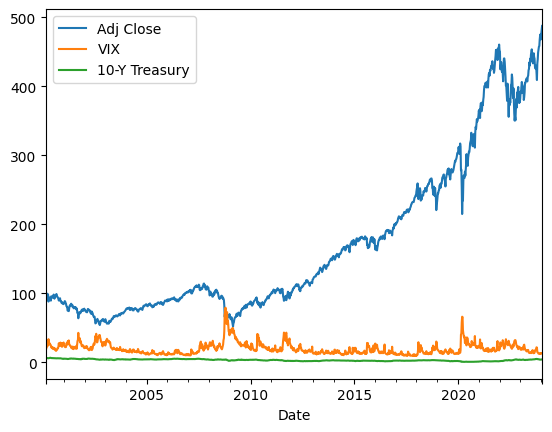

In [284]:
# Create plot to visualize the different indexes.
combined_df.plot.line(y=['Adj Close','VIX', '10-Y Treasury'], use_index=True)